# INTRODUCTION

E-commerce, or electronic commerce, refers to the buying and selling of goods and services over the Internet. With the rapid growth of online shopping platforms and digital marketplaces, e-commerce has become a crucial aspect of modern business operations. The rise of e-commerce has transformed the way businesses operate, enabling them to reach a global customer base and providing consumers with unparalleled convenience and access to a vast array of products and services.

Machine learning, a subset of artificial intelligence (AI), has revolutionized the e-commerce industry by offering numerous benefits and opportunities. Machine learning involves the development of algorithms and statistical models that enable systems to learn from data and make predictions or decisions without being explicitly programmed. In the context of e-commerce, machine learning techniques are employed in areas such as personalized recommendations, demand forecasting, pricing optimization, fraud detection, chatbots and virtual assistants, and image and text analysis. By leveraging machine learning technologies, e-commerce businesses can gain valuable insights, streamline operations, enhance customer experiences, and ultimately drive growth and profitability in an increasingly competitive online marketplace.

Through this report, we will demonstrate how machine learning can be used to predict quantity sold of products on any e-commerce platform, or in particular, Lazada.


# ETLS

## *Crawl dataset from Lazada using Selenium*

There are two common ways to crawl data using Python:

1. **Web Scraping**:
   Web scraping involves extracting information from websites by parsing the HTML content. Python provides several libraries for web scraping, such as **Beautiful Soup**, **Requests**, and **Scrapy**. Here's a brief overview of each:
   - **Beautiful Soup**: A powerful library for parsing HTML and XML documents. It allows you to navigate the document tree, extract specific elements, and retrieve data.
   - **Requests**: A popular library for making HTTP requests. You can use it to fetch web pages and then parse the content using Beautiful Soup.
   - **Scrapy**: A comprehensive framework for web crawling and data extraction. Scrapy provides built-in features like handling redirects, managing cookies, and following links.

2. **APIs and Data APIs**:
   Another way to collect data is by using APIs (Application Programming Interfaces). Many websites and services offer APIs that allow you to retrieve structured data directly. Here's how it works:
   - **RESTful APIs**: These APIs follow REST principles and provide endpoints to access specific data. You can use Python's **requests** library to make API calls and retrieve JSON or XML responses.
   - **Data APIs**: Some platforms, such as Twitter, GitHub, or Google Maps, offer specific APIs to access their data. For example, the Twitter API allows you to search for tweets, retrieve user profiles, and post tweets programmatically.

For Lazada, APIs are not available for crawling, thus web scraping is more appropriate than API crawling. To do so, we need to use `selenium` package. One thing to note that `selenium` will require a UI driver to execute. That's why you must have chromedriver.exe if you use Google Chrome for crawling. Here's how to download chromedriver.exe:
- Paste this link onto the search bar: https://storage.googleapis.com/chrome-for-testing-public/115.0.5763.0/win64/chromedriver-win64.zip
- Once it's automatically downloaded, unzip the files and copy the file `chromedriver.exe` into the folder that contains this notebook.

Here's how you can do it. 

In [5]:
# !pip3 install selenium
!pip3 install webdriver-manager


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [7]:
!chmod +x ./chromedriver/chromedriver.exe

In [9]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver import ActionChains
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from time import sleep
import numpy as np
import pandas as pd
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException

# Set Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")

# Set path to chromedriver as a Service object
webdriver_service = Service(ChromeDriverManager().install())

# Declare browser
driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)

# Crawl all the dataset
page = 1
df = pd.DataFrame()
while page <= 101:
    # Open browser
    driver.get(f'https://www.lazada.vn/cac-loai-tai-nghe/?page={page}&spm=a2o4n.searchlistcategory.cate_1_5.1.180c25bcBWpu23')
    sleep(2)

    # Set up WebDriverWait
    wait = WebDriverWait(driver, 4)

    # Get link/title of each item
    elements = driver.find_elements(By.CSS_SELECTOR, '.RfADt [href]')
    title = [element.text for element in elements]
    links = [element.get_attribute('href') for element in elements]

    # Get price
    element_price = driver.find_elements(By.CSS_SELECTOR, '.aBrP0')
    prices = [element.text for element in element_price]

    df1 = pd.DataFrame(list(zip(title, prices, links)), columns=['title', 'price', 'link_item'])
    df1['index_'] = np.arange(1, len(df1) + 1)

    discount_idx, discount_percent_list = [], []
    if page == 1:
        for i in range(1, len(title) + 1):  # Iterate through DataFrame rows
            try:
                # Use CSS selector to target discount element
                discount_per = driver.find_element('xpath',
                                                   '/html/body/div[3]/div/div[3]/div[1]/div/div[1]/div[2]/div[{}]/div/div/div[2]/div[4]/span'.format(i))
                discount_percent_list.append(discount_per.text)
                discount_idx.append(i)  # Adjust index for DataFrame row
            except (TimeoutException, NoSuchElementException, ElementNotInteractableException):
                print(f'No discount found for item {i} or timeout occurred')
                discount_percent_list.append(np.nan)  # Add 'NA' for missing values
                discount_idx.append(i)
    else:
        for i in range(1, len(title) + 1):  # Iterate through DataFrame rows
            try:
                # Use CSS selector to target discount element
                discount_per = driver.find_element('xpath',
                                                   '/html/body/div[3]/div/div[2]/div[1]/div/div[1]/div[2]/div[{}]/div/div/div[2]/div[4]/span'.format(i))
                discount_percent_list.append(discount_per.text)
                discount_idx.append(i)  # Adjust index for DataFrame row
            except (TimeoutException, NoSuchElementException, ElementNotInteractableException):
                print(f'No discount found for item {i} or timeout occurred')
                discount_percent_list.append(np.nan)  # Add 'NA' for missing values
                discount_idx.append(i)

    df2 = pd.DataFrame(list(zip(discount_idx, discount_percent_list)), columns=['discount_idx', 'discount_percent_list'])
    df3 = df1.merge(df2, how = 'left', left_on = 'index_', right_on = 'discount_idx')

    # Get location/number of reviews
    elements_countReview = driver.find_elements(By.CSS_SELECTOR, '._6uN7R')
    countReviews = [element.text for element in elements_countReview]
    df3['countReviews'] = countReviews

    df = pd.concat([df, df3], ignore_index = True)
    page += 1
    
df.info()

No discount found for item 1 or timeout occurred
No discount found for item 2 or timeout occurred
No discount found for item 3 or timeout occurred
No discount found for item 4 or timeout occurred
No discount found for item 5 or timeout occurred
No discount found for item 6 or timeout occurred
No discount found for item 7 or timeout occurred
No discount found for item 8 or timeout occurred
No discount found for item 9 or timeout occurred
No discount found for item 10 or timeout occurred
No discount found for item 11 or timeout occurred
No discount found for item 12 or timeout occurred
No discount found for item 13 or timeout occurred
No discount found for item 14 or timeout occurred
No discount found for item 15 or timeout occurred
No discount found for item 16 or timeout occurred
No discount found for item 17 or timeout occurred
No discount found for item 18 or timeout occurred
No discount found for item 19 or timeout occurred
No discount found for item 20 or timeout occurred
No discou

In [10]:
df.head()

,title,price,link_item,index_,discount_idx,discount_percent_list,countReviews
0,Bluetooth Earphone Bluetooth Headset Sports He...,414.669 ₫,https://www.lazada.vn/products/bluetooth-earph...,1,1,NaN,China
1,Bnlight Tai nghe trẻ em khủng long dễ thương T...,161.000 ₫,https://www.lazada.vn/products/bnlight-tai-ngh...,2,2,NaN,Nước ngoài
2,(MEBR) Replacement Gaming Headphone Omnidirect...,167.000 ₫,https://www.lazada.vn/products/mebr-replacemen...,3,3,NaN,China
3,(MEBR) Replacement Gaming Headphone Omnidirect...,167.000 ₫,https://www.lazada.vn/products/mebr-replacemen...,4,4,NaN,China
4,K75 Lavalier Bluetooth 5.4 Tai Nghe Kinh Doanh...,294.700 ₫,https://www.lazada.vn/products/k75-lavalier-bl...,5,5,NaN,210 Đã bán\nChina


## *Data Cleaning*

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  480 non-null    object
 1   price                  480 non-null    object
 2   link_item              480 non-null    object
 3   index_                 480 non-null    object
 4   discount_idx           480 non-null    object
 5   discount_percent_list  0 non-null      object
 6   countReviews           480 non-null    object
dtypes: object(7)
memory usage: 26.4+ KB


In [12]:
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].str[:-2]
df['price'] = df['price'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title                  480 non-null    object
 1   price                  480 non-null    int64 
 2   link_item              480 non-null    object
 3   index_                 480 non-null    object
 4   discount_idx           480 non-null    object
 5   discount_percent_list  0 non-null      object
 6   countReviews           480 non-null    object
dtypes: int64(1), object(6)
memory usage: 26.4+ KB


In [13]:
df = df.drop(['index_', 'discount_idx'], axis = 1)

In [14]:
df['discount_percent_list'] = df['discount_percent_list'].str[:-5]
df['discount_percent_list'] = df['discount_percent_list'].astype(float) / 100
df.head()

,title,price,link_item,discount_percent_list,countReviews
0,Bluetooth Earphone Bluetooth Headset Sports He...,414669,https://www.lazada.vn/products/bluetooth-earph...,NaN,China
1,Bnlight Tai nghe trẻ em khủng long dễ thương T...,161000,https://www.lazada.vn/products/bnlight-tai-ngh...,NaN,Nước ngoài
2,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,NaN,China
3,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,NaN,China
4,K75 Lavalier Bluetooth 5.4 Tai Nghe Kinh Doanh...,294700,https://www.lazada.vn/products/k75-lavalier-bl...,NaN,210 Đã bán\nChina


In [15]:
import re

# Tạo cột "location_of_product"
def extract_location(x):
    if '\n' in x:
        return x.split('\n')[-1]
    elif re.match("^[a-zA-Z]*$", x):
        return x
    elif 'Đã bán' in x or re.search(r'\((.*?)\)', x):
        return np.nan
    else:
        return x

df['location_of_product'] = df['countReviews'].apply(extract_location)

# Tạo cột "quantity_sold"
def extract_quantity(x):
    if 'Đã bán' in x.split('\n')[0]:
        return x.split('\n')[0]
    elif 'Đã bán' in x and '\n' not in x:
        return x
    else:
        return np.nan

df['quantity_sold'] = df['countReviews'].apply(extract_quantity)

# Tạo cột "review_count"
def extract_review(x):
    if re.search(r'\((.*?)\)', x):
        return re.search(r'\((.*?)\)', x).group(1)
    elif re.search(r'\((.*?)\)', x) and '\n' not in x:
        return x
    else:
        return np.nan

df['review_count'] = df['countReviews'].apply(extract_review)

df

,title,price,link_item,discount_percent_list,countReviews,location_of_product,quantity_sold,review_count
0,Bluetooth Earphone Bluetooth Headset Sports He...,414669,https://www.lazada.vn/products/bluetooth-earph...,NaN,China,China,NaN,NaN
1,Bnlight Tai nghe trẻ em khủng long dễ thương T...,161000,https://www.lazada.vn/products/bnlight-tai-ngh...,NaN,Nước ngoài,Nước ngoài,NaN,NaN
2,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,NaN,China,China,NaN,NaN
3,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,NaN,China,China,NaN,NaN
4,K75 Lavalier Bluetooth 5.4 Tai Nghe Kinh Doanh...,294700,https://www.lazada.vn/products/k75-lavalier-bl...,NaN,210 Đã bán\nChina,China,210 Đã bán,NaN
...,...,...,...,...,...,...,...,...
475,Dây Đeo Đầu Bluetooth Không Dây Đàn Hồi Mặt Nạ...,136000,https://www.lazada.vn/products/day-deo-dau-blu...,NaN,China,China,NaN,NaN
476,Tai nghe mèo dễ thương có đèn LED Tai nghe Blu...,97000,https://www.lazada.vn/products/tai-nghe-meo-de...,NaN,China,China,NaN,NaN
477,Tai Nghe Nhét Tai Nghe Nhét Tai OWS Cao Cấp T3...,34000,https://www.lazada.vn/products/tai-nghe-nhet-t...,NaN,5 Đã bán\n(2)\nChina,China,5 Đã bán,2
478,WENSH Cho PC Có thể điều chỉnh Stereo HIFI Âm ...,98075,https://www.lazada.vn/products/wensh-cho-pc-co...,NaN,China,China,NaN,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  480 non-null    object 
 1   price                  480 non-null    int64  
 2   link_item              480 non-null    object 
 3   discount_percent_list  0 non-null      float64
 4   countReviews           480 non-null    object 
 5   location_of_product    480 non-null    object 
 6   quantity_sold          103 non-null    object 
 7   review_count           14 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 30.1+ KB


In [18]:
!pip3 install seaborn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [ ]:
# Clean column discount_percent_list
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
sns.set_style('whitegrid')

fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.boxplot(df['discount_percent_list'], ax = ax[0], color = 'green')
sns.distplot(df['discount_percent_list'], ax = ax[1], color = 'green')

From here, we have 4 ways to fill in the null values, which were filling with 0, with mean, with median and with mode. However, if we look at the web page, we can see that most products with `NaN` values in column `discount_percent_list` don't have any discounts. Thus, we can replace all the null values in column `discount_percent_list` with 0.

In [20]:
# Fill the null values with 0.0
df['discount_percent_list'] = df['discount_percent_list'].fillna(0.0)

Next up, we will deal with column `quantity_sold`

In [21]:
df['quantity_sold'].unique()

array([nan, '210 Đã bán', '1.5K Đã bán', '26 Đã bán', '133 Đã bán',
       '391 Đã bán', '60 Đã bán', '18 Đã bán', '50 Đã bán', '5 Đã bán',
       '76 Đã bán', '53 Đã bán', '25 Đã bán', '442 Đã bán', '49 Đã bán',
       '126 Đã bán', '370 Đã bán', '1.0K Đã bán', '735 Đã bán',
       '301 Đã bán', '200 Đã bán', '10 Đã bán', '101 Đã bán',
       '107 Đã bán', '125 Đã bán', '63 Đã bán', '29 Đã bán', '45 Đã bán',
       '56 Đã bán', '499 Đã bán', '78 Đã bán', '47 Đã bán', '11 Đã bán',
       '23 Đã bán', '48 Đã bán', '7 Đã bán', '104 Đã bán', '28 Đã bán',
       '175 Đã bán', '6 Đã bán', '818 Đã bán', '225 Đã bán', '174 Đã bán',
       '27 Đã bán', '74 Đã bán', '515 Đã bán', '21 Đã bán', '80 Đã bán',
       '12 Đã bán', '118 Đã bán', '96 Đã bán', '20 Đã bán', '82 Đã bán',
       '120 Đã bán', '147 Đã bán', '533 Đã bán', '223 Đã bán',
       '241 Đã bán', '91 Đã bán', '90 Đã bán', '38 Đã bán', '17 Đã bán',
       '2.8K Đã bán', '426 Đã bán', '58 Đã bán', '64 Đã bán',
       '850 Đã bán', '3

So, there are two issues with this column to be dealt:
- First, remove the phrase `' Đã bán'` out of this, and then change values with `'K'` into thousands. Make sure the data are in integer type. 
- Second, eliminate or fill the null values with something else?

Let's deal problem 1 first.

In [22]:
# Delete ' Đã bán'
df['quantity_sold'] = df['quantity_sold'].str.replace(' Đã bán', '', regex=False)

# If any line has the letter K, multiply 1000 into that line's value
df['quantity_sold'] = df['quantity_sold'].apply(lambda x: float(x.replace('K', '')) * 1000 if 'K' in str(x) else x)

# View the results:
df.head()

,title,price,link_item,discount_percent_list,countReviews,location_of_product,quantity_sold,review_count
0,Bluetooth Earphone Bluetooth Headset Sports He...,414669,https://www.lazada.vn/products/bluetooth-earph...,0.0,China,China,NaN,NaN
1,Bnlight Tai nghe trẻ em khủng long dễ thương T...,161000,https://www.lazada.vn/products/bnlight-tai-ngh...,0.0,Nước ngoài,Nước ngoài,NaN,NaN
2,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,0.0,China,China,NaN,NaN
3,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,0.0,China,China,NaN,NaN
4,K75 Lavalier Bluetooth 5.4 Tai Nghe Kinh Doanh...,294700,https://www.lazada.vn/products/k75-lavalier-bl...,0.0,210 Đã bán\nChina,China,210,NaN


Now, since there are still missing values in column `quantity_sold`, we will have to examine it to figure out how to deal with them.

Max value of column quantity sold: 2800
Min value of column quantity sold: 5


<Axes: xlabel='quantity_sold', ylabel='Density'>

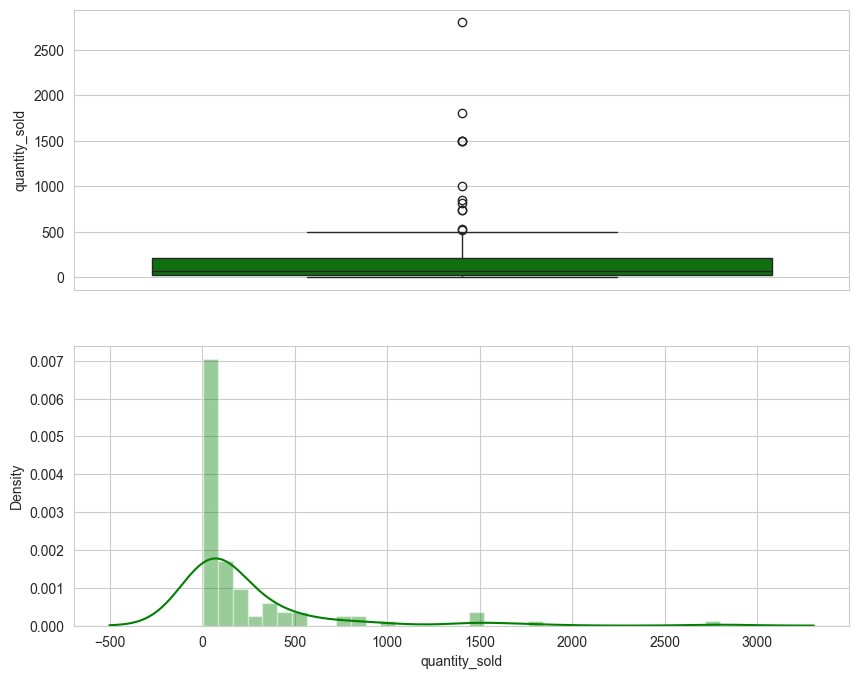

In [23]:
print(f'Max value of column quantity sold: {df["quantity_sold"].dropna().astype(int).max()}')
print(f'Min value of column quantity sold: {df["quantity_sold"].dropna().astype(int).min()}')
# Box plot and histogram would help us in this case
# For the sake of plotting, we would alter a bit of data by dropping null values out
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.boxplot(df['quantity_sold'].dropna().astype(int), ax = ax[0], color = 'green')
sns.distplot(df['quantity_sold'].dropna().astype(int), ax = ax[1], color = 'green')

We can see that there are a huge amount of outliers in this case. Thus, to make it less right-skewed, we can fill the null values with mode or median - they have the same effect. In this case, we will fill the nulls with mode.

In [24]:
df['quantity_sold'] = df['quantity_sold'].fillna(df['quantity_sold'].mode()[0])
df.sample(5)

,title,price,link_item,discount_percent_list,countReviews,location_of_product,quantity_sold,review_count
43,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,0.0,China,China,5,NaN
446,[Fortitudes] Tai Nghe Cho Trẻ Em Có Dây Máy Tí...,73793,https://www.lazada.vn/products/fortitudes-tai-...,0.0,China,China,5,NaN
305,Tai Nghe Bluetooth Không Dây Thực Sự Air Pro Â...,138600,https://www.lazada.vn/products/tai-nghe-blueto...,0.0,120 Đã bán\nChina,China,120,NaN
422,Tai Nghe Bluetooth 5.0 Âm Thanh Nổi Y08 Tai Ng...,109000,https://www.lazada.vn/products/tai-nghe-blueto...,0.0,China,China,5,NaN
260,[huguosheng] 1PC tai nghe 3.5mm cắm duy nhất b...,14618,https://www.lazada.vn/products/huguosheng-1pc-...,0.0,China,China,5,NaN


For the last column, which is `review_count`, we would also look at its distribution and IQR chart to see whether we can fill with anything special.

<Axes: xlabel='review_count', ylabel='Density'>

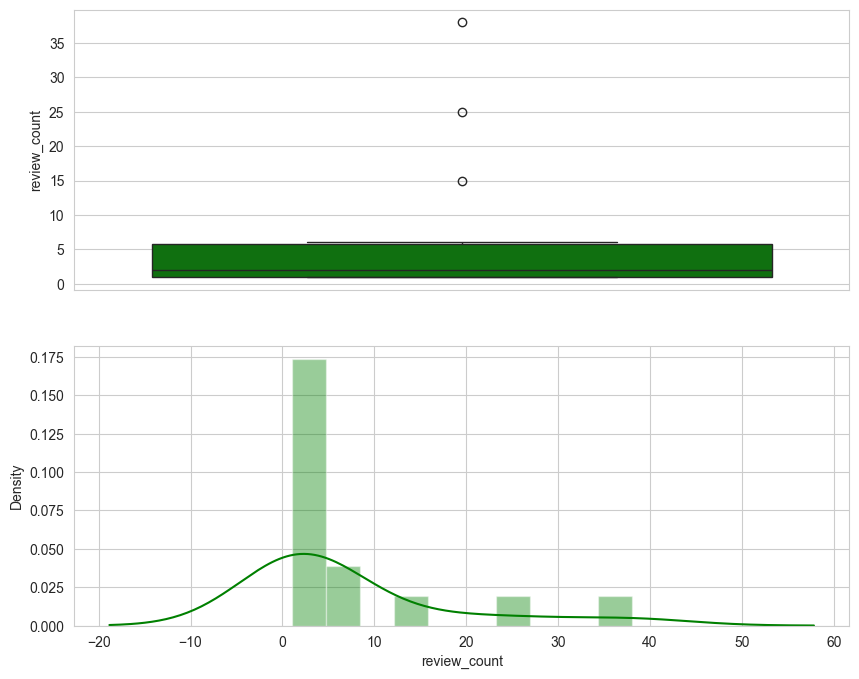

In [25]:
# For the sake of plotting, we would alter a bit of data by dropping null values out
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.boxplot(df['review_count'].dropna().astype(int), ax = ax[0], color = 'green')
sns.distplot(df['review_count'].dropna().astype(int), ax = ax[1], color = 'green')

Just like `quantity_sold`, this column also has a lot of outliers. For this time, we would fill the null values with median because replacing null values with mean will create blunders as it contains outliers and mean is influenced with outliers.

In [ ]:
df['review_count'] = df['review_count'].fillna(df['review_count'].median())
df.info()

Perfect! We have done filling the datasets with null values. Now, let's check if there are any duplicated values.

In [27]:
df[df.duplicated()]

,title,price,link_item,discount_percent_list,countReviews,location_of_product,quantity_sold,review_count
40,Bluetooth Earphone Bluetooth Headset Sports He...,414669,https://www.lazada.vn/products/bluetooth-earph...,0.0,China,China,5,NaN
41,Bnlight Tai nghe trẻ em khủng long dễ thương T...,161000,https://www.lazada.vn/products/bnlight-tai-ngh...,0.0,Nước ngoài,Nước ngoài,5,NaN
42,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,0.0,China,China,5,NaN
43,(MEBR) Replacement Gaming Headphone Omnidirect...,167000,https://www.lazada.vn/products/mebr-replacemen...,0.0,China,China,5,NaN
44,K75 Lavalier Bluetooth 5.4 Tai Nghe Kinh Doanh...,294700,https://www.lazada.vn/products/k75-lavalier-bl...,0.0,210 Đã bán\nChina,China,210,NaN
45,KESTRE MP3 Âm thanh HIFI Âm Nhạc Linh hoạt Ste...,83075,https://www.lazada.vn/products/kestre-mp3-am-t...,0.0,China,China,5,NaN
46,Tai Nghe Disney Minnie MickeyTWS Bluetooth 5.3...,195500,https://www.lazada.vn/products/tai-nghe-disney...,0.0,China,China,5,NaN
47,Tai Nghe Không Dây Dẫn Truyền Xương Bluetooth ...,198900,https://www.lazada.vn/products/tai-nghe-khong-...,0.0,1.5K Đã bán\nChina,China,1500.0,NaN
49,Tai Nghe Đài FM Di Động AIBEN C201PRO Có Giắc ...,118300,https://www.lazada.vn/products/tai-nghe-dai-fm...,0.0,26 Đã bán\nChina,China,26,NaN
50,RIUERSTONE Chất lượng Cầm tay Màu đen Điện tho...,32223,https://www.lazada.vn/products/riuerstone-chat...,0.0,China,China,5,NaN


Luckily, there are no duplicates for our datasets. So, it's good enough for some exploratory data analysis.

# EDAS

## *Univariate analysis*

### Price

For visualizing the price of each item, it's best to use histogram or box plot to serve this purpose.

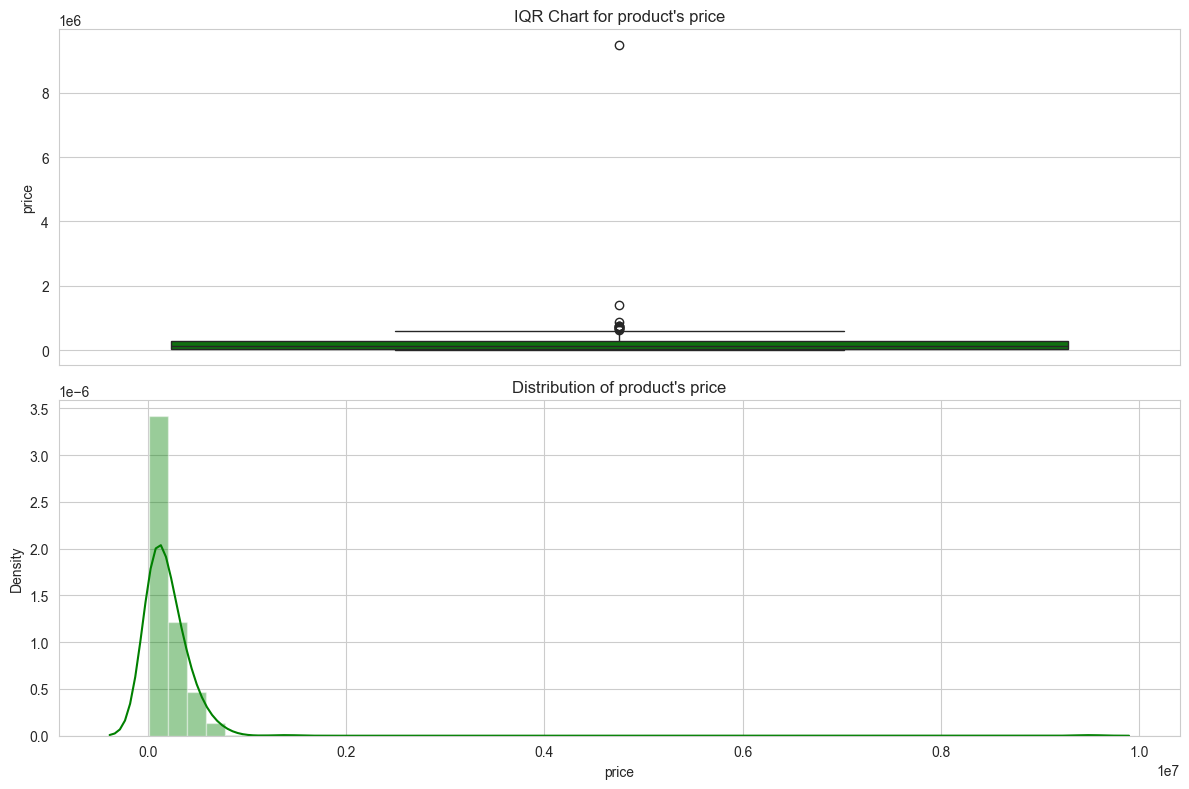

In [28]:
fig, axs = plt.subplots(2, 1, figsize = (12, 8))
sns.boxplot(df['price'], ax = axs[0], color = 'green')
axs[0].set_title('IQR Chart for product\'s price')
sns.distplot(df['price'], ax = axs[1], color = 'green', kde = True, bins = 50)
axs[1].set_title('Distribution of product\'s price')
plt.tight_layout()

For the box plot:
- The majority of the earphone prices are clustered near the lower end of the price range, indicating that most earphones on Lazada are relatively cheap.
- There are some earphones with prices significantly higher than the majority, as shown by the long whisker extending to the right.
- There are a few outliers represented by individual points along this whisker, indicating that there are a few earphones that are priced much higher than the rest.

For the histogram:
- Most earphone prices are concentrated at the lower end, with a peak just before 0.25 on the x-axis labeled ‘price’. This again suggests that most earphones on Lazada are relatively cheap.
- The tail of the distribution extends towards higher prices but drops off quickly, suggesting that high-priced earphones are much less common.

This indicates that there is a wide range of earphone prices on Lazada, but most of them are at the lower end of the spectrum.

### Discount percent

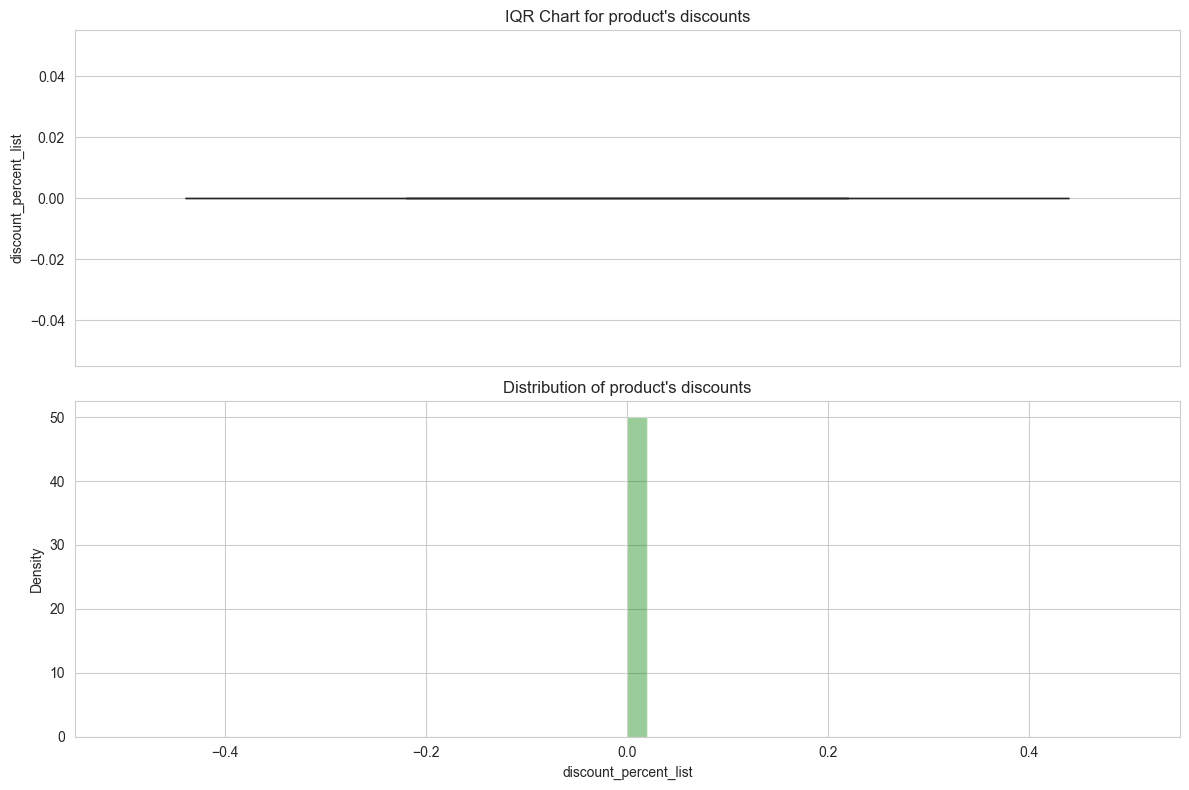

In [29]:
fig, axs = plt.subplots(2, 1, figsize = (12, 8))
sns.boxplot(df['discount_percent_list'], ax = axs[0], color = 'green')
axs[0].set_title('IQR Chart for product\'s discounts')
sns.distplot(df['discount_percent_list'], ax = axs[1], color = 'green', kde = True, bins = 50)
axs[1].set_title('Distribution of product\'s discounts')
plt.tight_layout()

For the box plot:
- The majority of the discounts are concentrated in a relatively narrow range, indicating that most earphones on Lazada have similar discount percentages.
- The median discount percentage is around 0.2 or 20%, indicated by the line within the green box.
- There are several data points beyond the upper whisker that could be considered outliers, indicating that there are a few earphones that have much higher discounts than the rest.

For the density plot:
- There is a high frequency of products with very low discounts (close to 0%), and then there’s a gradual increase in frequency peaking around 20% before tapering off again.
- This suggests that while most products have modest discounts, there are quite a few with very low or no discounts at all.

Both graphs provide insights into how earphone discounts vary on Lazada, highlighting that while there is a wide range of discounts available, most products fall within a similar discount percentage with fewer options offering high discounts.

### Quantity sold

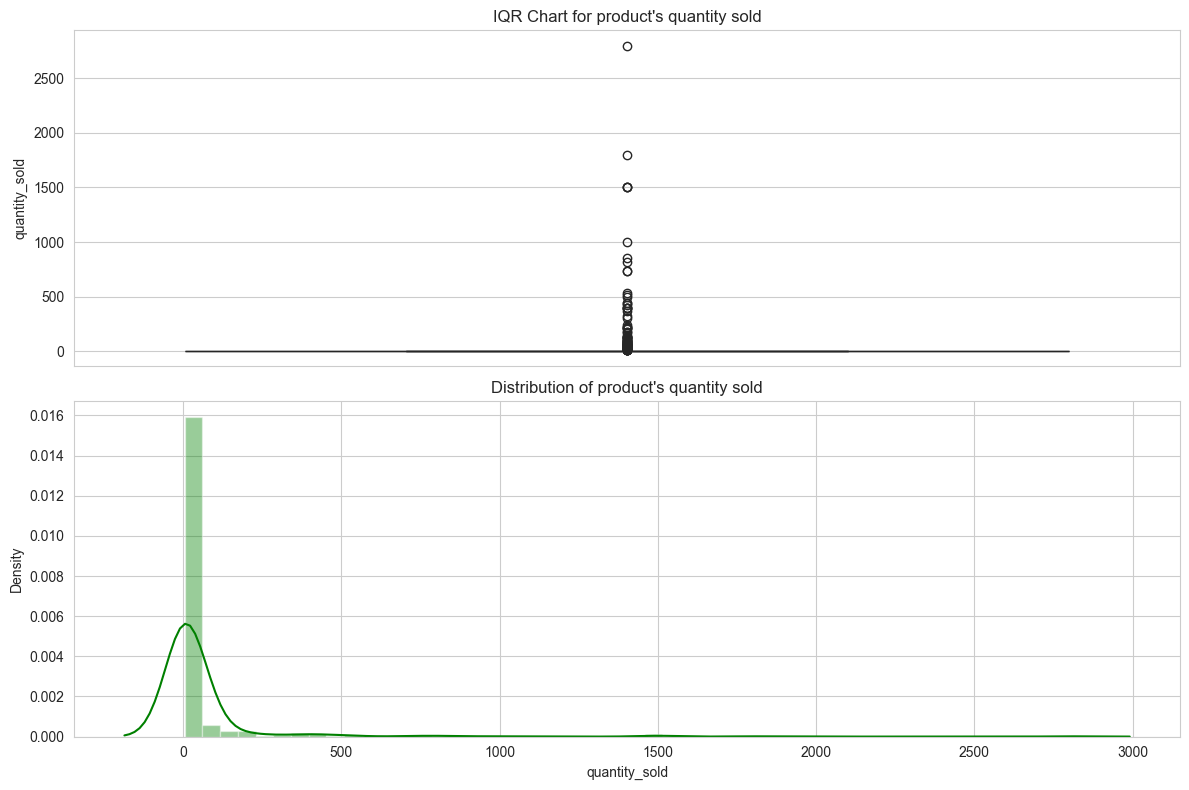

In [30]:
# Cast type
df['quantity_sold'] = df['quantity_sold'].astype(int)

fig, axs = plt.subplots(2, 1, figsize = (12, 8))
sns.boxplot(df['quantity_sold'], ax = axs[0], color = 'green')
axs[0].set_title('IQR Chart for product\'s quantity sold')
sns.distplot(df['quantity_sold'], ax = axs[1], color = 'green', kde = True, bins = 50)
axs[1].set_title('Distribution of product\'s quantity sold')
plt.tight_layout()

For the box plot:
- The majority of the earphones on Lazada have similar sales quantities, as indicated by the main box of the plot.
- There are numerous data points beyond the whiskers, which are considered outliers. This indicates that there are a few earphones that have much higher sales quantities than the rest.

For the density plot:
- The distribution curve peaks close to zero with a long right tail, indicating that most of the earphones have low sales quantities.
- However, there are some instances with very high sales, as indicated by the long tail of the distribution.

Both graphs provide insights into how earphone sales on Lazada are distributed, highlighting that while most products sell in smaller quantities, there are exceptions with significantly higher sales. This information could be relevant for analyzing sales performance or inventory management.

### Reviews count

In [ ]:
# Cast type
df['review_count'] = df['review_count'].astype(int)

fig, axs = plt.subplots(2, 1, figsize = (12, 8))
sns.boxplot(df['review_count'], ax = axs[0], color = 'green')
axs[0].set_title('IQR Chart for product\'s review count')
sns.distplot(df['review_count'], ax = axs[1], color = 'green', kde = True, bins = 50)
axs[1].set_title('Distribution of product\'s review count')
plt.tight_layout()

For the box plot:
- The majority of the earphones on Lazada have similar counts of reviews, as indicated by the main box of the plot.
- There are numerous data points beyond the whiskers, which are considered outliers. This indicates that there are a few earphones that have much higher counts of reviews than the rest.

For the density plot:
- The distribution curve peaks sharply near the lower end, indicating that most of the earphones have a low count of reviews.
- However, there are some instances with very high counts of reviews, as indicated by the long tail of the distribution.

Both graphs provide insights into how the count of reviews for earphones on Lazada are distributed, highlighting that while most products have fewer reviews, there are exceptions with significantly higher counts of reviews. This information could be relevant for analyzing customer feedback or product popularity.

### Location of products

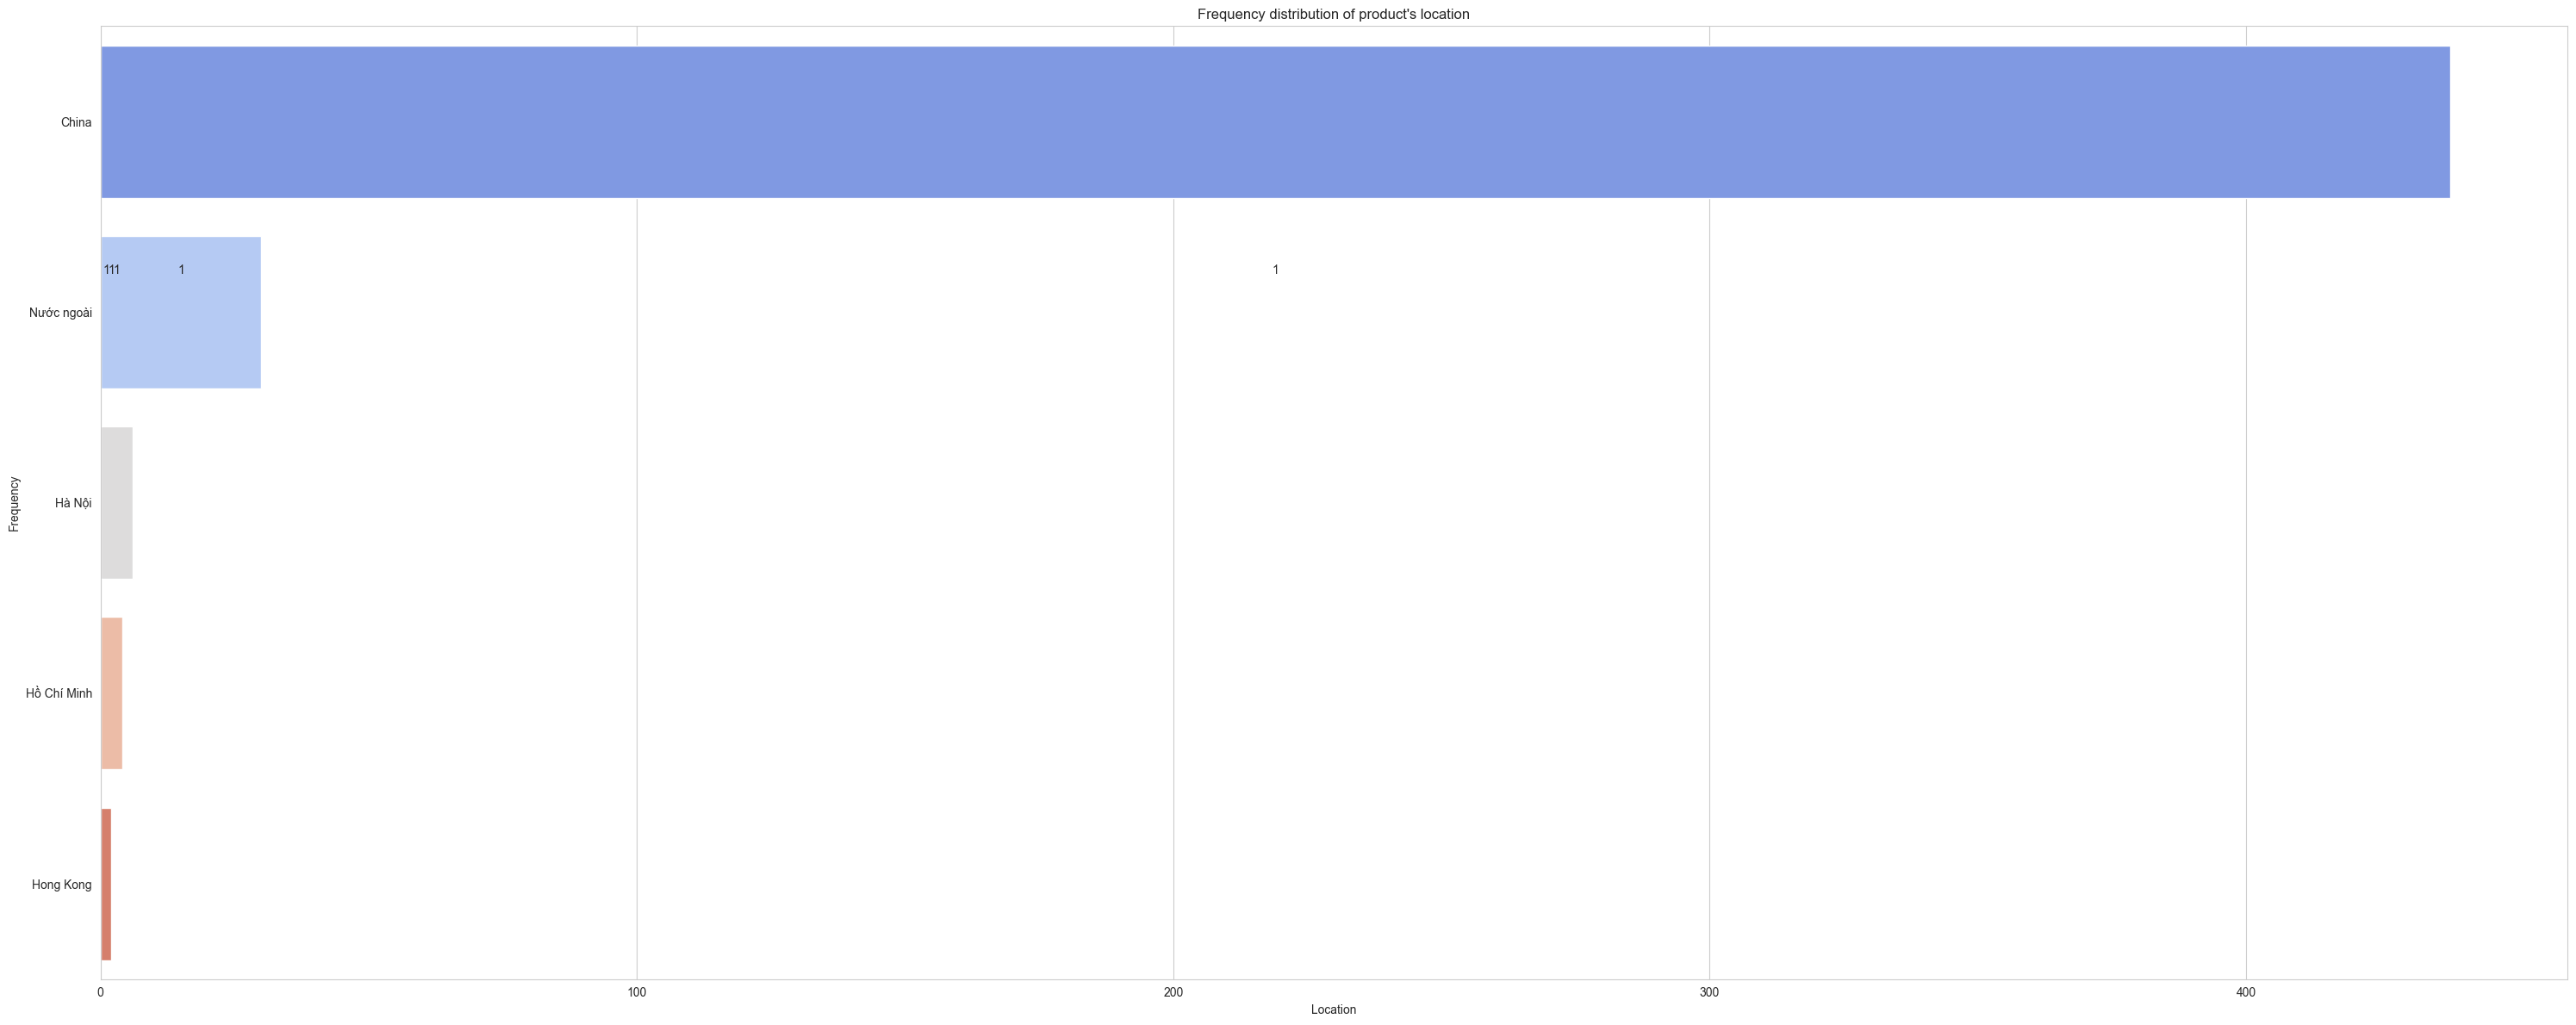

In [32]:
plt.figure(figsize = (30, 12))
ax = sns.countplot(df['location_of_product'], palette = 'coolwarm')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2,
                 p.get_height()), ha = 'center', va = 'center',
                size = 10, xytext = (0, 3),
                textcoords = 'offset points')
plt.title('Frequency distribution of product\'s location')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.tight_layout()

From this graph, we can clearly see that most earphones on platform are not located within the territory of Vietnam. There might be a significant number of international sellers on Lazada Vietnam who are selling their products in the country. This could be due to the global nature of e-commerce platforms which allows sellers from around the world to list their products. 

Second in the list is Ho Chi Minh city, which indicates that most earphones are stocked in Ho Chi Minh city. This is due to the fact that Ho Chi Minh city is Vietnam's leading economic and technological city. 

## *Bivariate analysis*

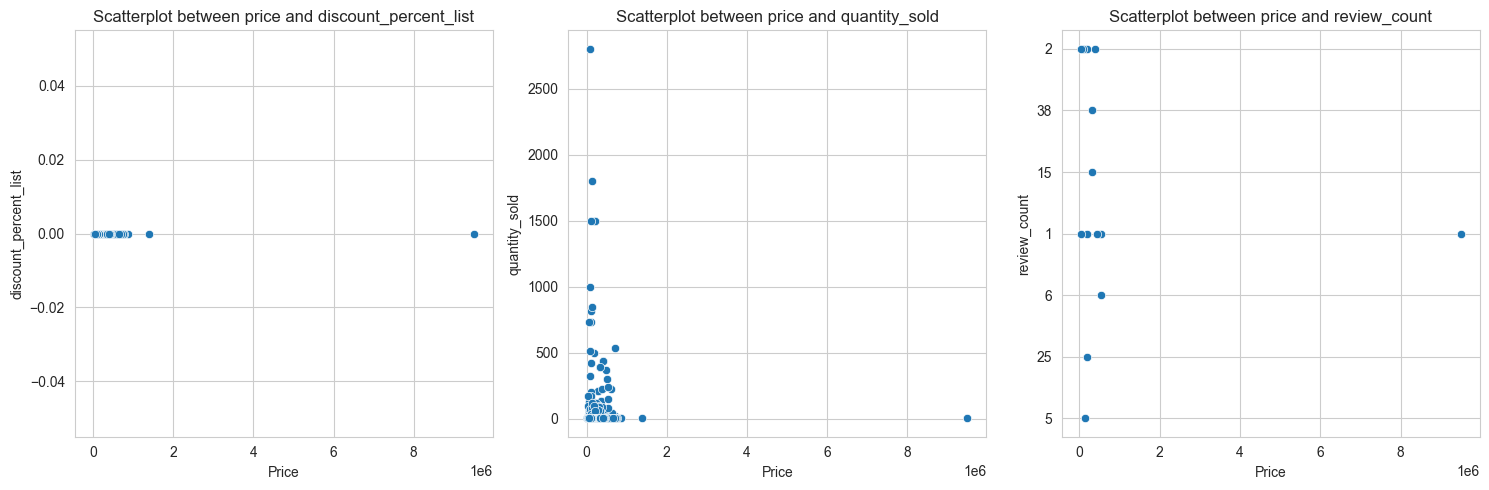

In [33]:
cols = ['discount_percent_list', 'quantity_sold', 'review_count']
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, col in enumerate(cols):
    sns.scatterplot(data = df, x = 'price', y = col, ax = axs[i])
    axs[i].set_title(f'Scatterplot between price and {col}')
    axs[i].set_xlabel('Price')
    axs[i].set_ylabel(col)
plt.tight_layout()

The first graph is a scatter plot between **Price** and **Discount Percent**. Here are some observations:
- The data points are concentrated mostly at the lower end of both axes, indicating that earphones with lower prices tend to have a higher percentage of discounts.
- There is a visible decrease in discount percentage as the price increases, suggesting that more expensive earphones may have smaller relative discounts.

The second graph is a scatter plot between **Price** and **Quantity Sold**. Here are some observations:
- The majority of data points are clustered near the origin, showing that earphones with lower prices have higher sales quantities.
- There is a sharp decline in quantity sold as price increases, which could imply that customers prefer more affordable options when it comes to purchasing earphones.

The third graph is a scatter plot between **Price** and **Review Count**. Here are some observations:
- There is a high concentration of data points near the bottom left corner, indicating that cheaper earphones receive more reviews.
- As with quantity sold, review count also decreases as price increases.

Each plot provides insights into consumer behavior related to earphone purchases on Lazada: customers tend to favor affordability as indicated by higher discount percentages, greater quantities sold, and more reviews for less expensive options. This suggests that price is a significant factor influencing purchase decisions for earphones in this marketplace.

Text(0, 0.5, 'Price')

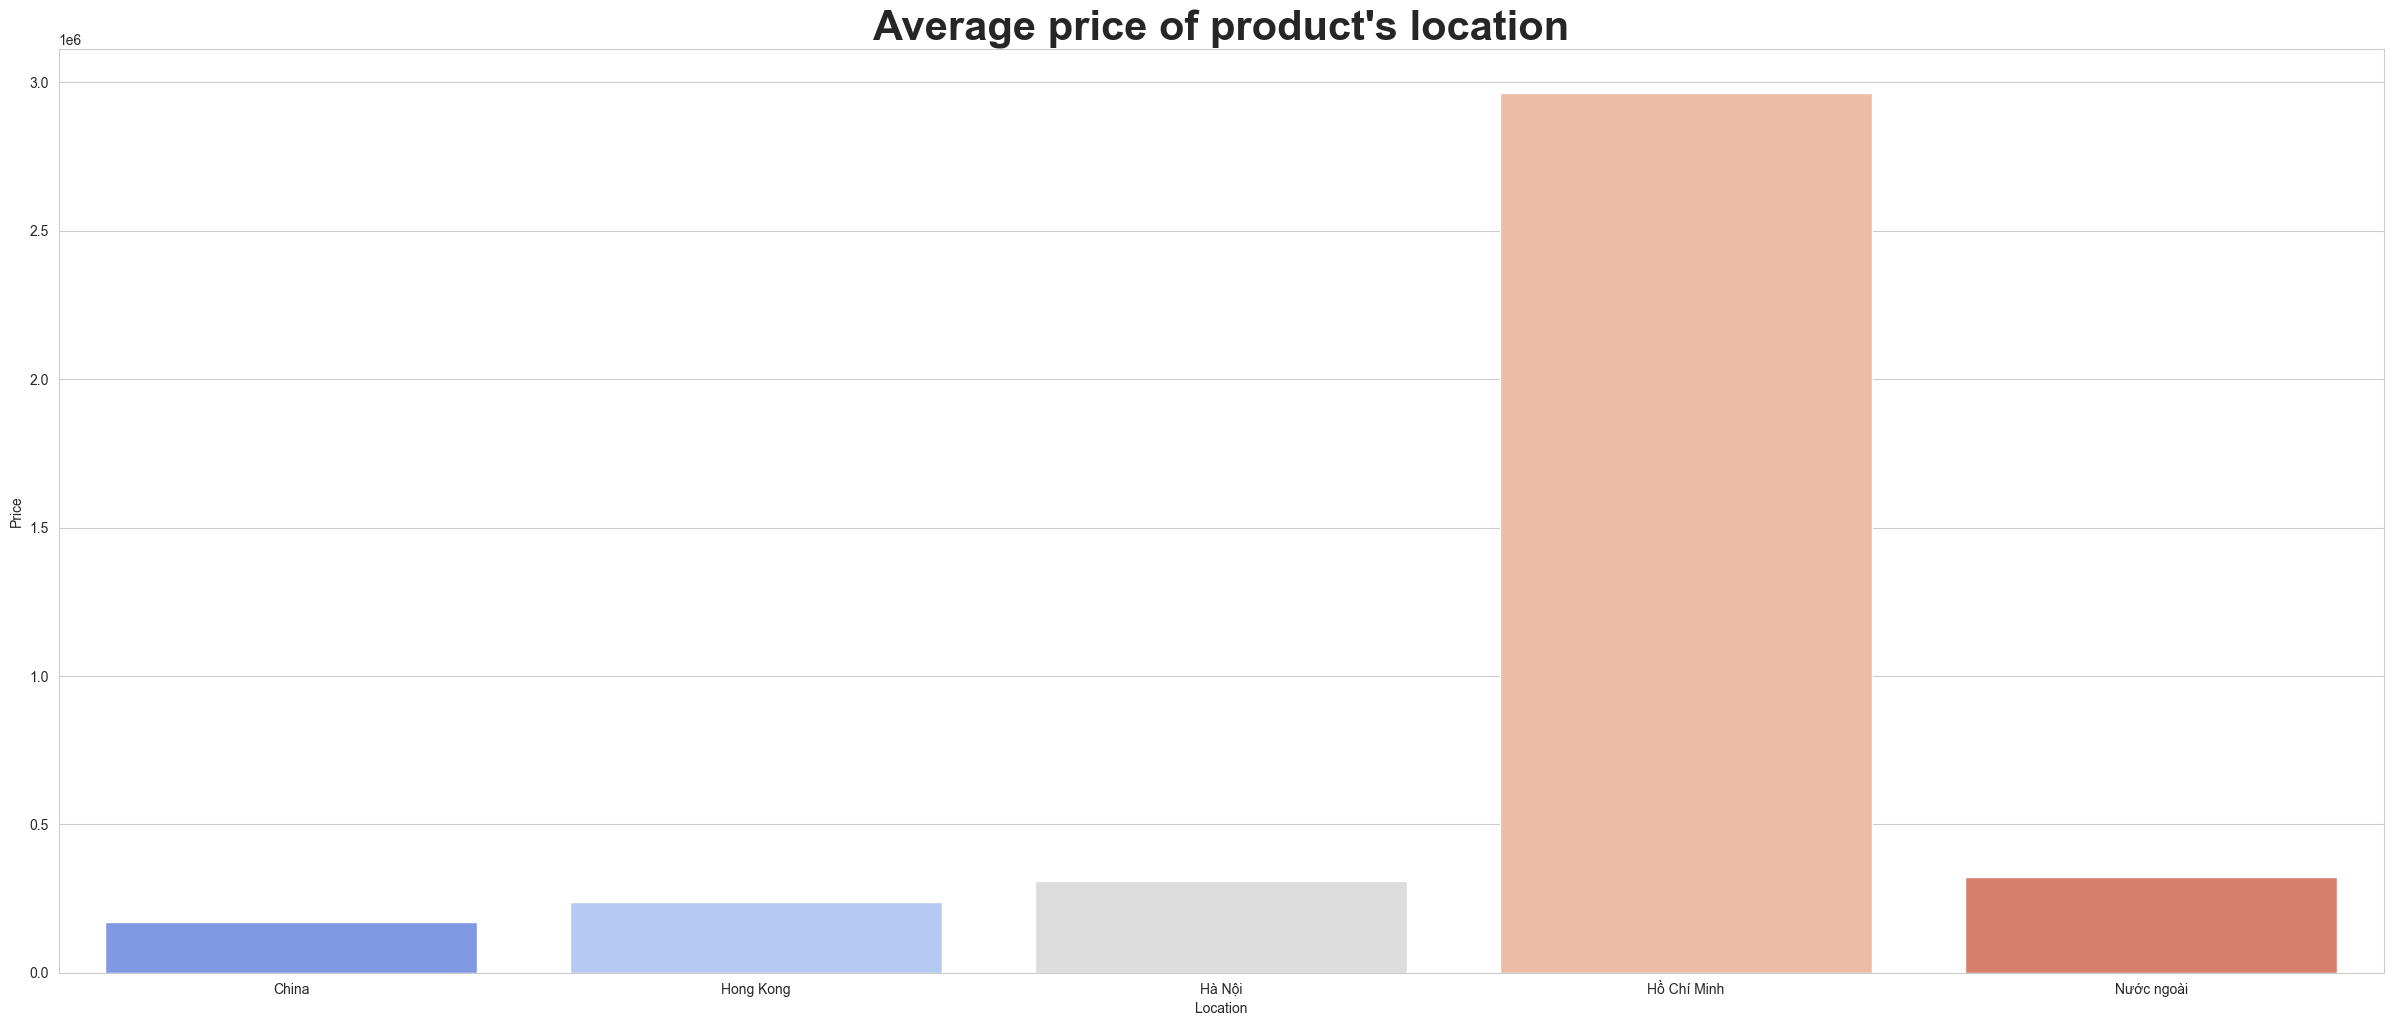

In [34]:
temp = df.groupby('location_of_product')['price'].mean().sort_index().reset_index()
plt.figure(figsize = (30, 12))
sns.barplot(data = temp,
            x = 'location_of_product', y = 'price', palette = 'coolwarm')
plt.title('Average price of product\'s location', fontweight = 'bold', fontsize = 30)
plt.xlabel('Location')
plt.ylabel('Price')

From this bar plot, we can clearly see Binh Dinh, Hai Phong and Thai Binh have the highest average price for earphone products on Lazada. This comes from the fact that warehouses are located here, but since the demand is higher elsewhere, thus leading to prices higher due to the distance travelled between warehouses and customers' homes. Whereas, Khanh Hoa, Vinh Phuc and Ba Ria - Vung Tau have the lowest average price for earphone products. This can be explained by the low demand for this kind of product in those three provinces.

Text(0, 0.5, 'Price')

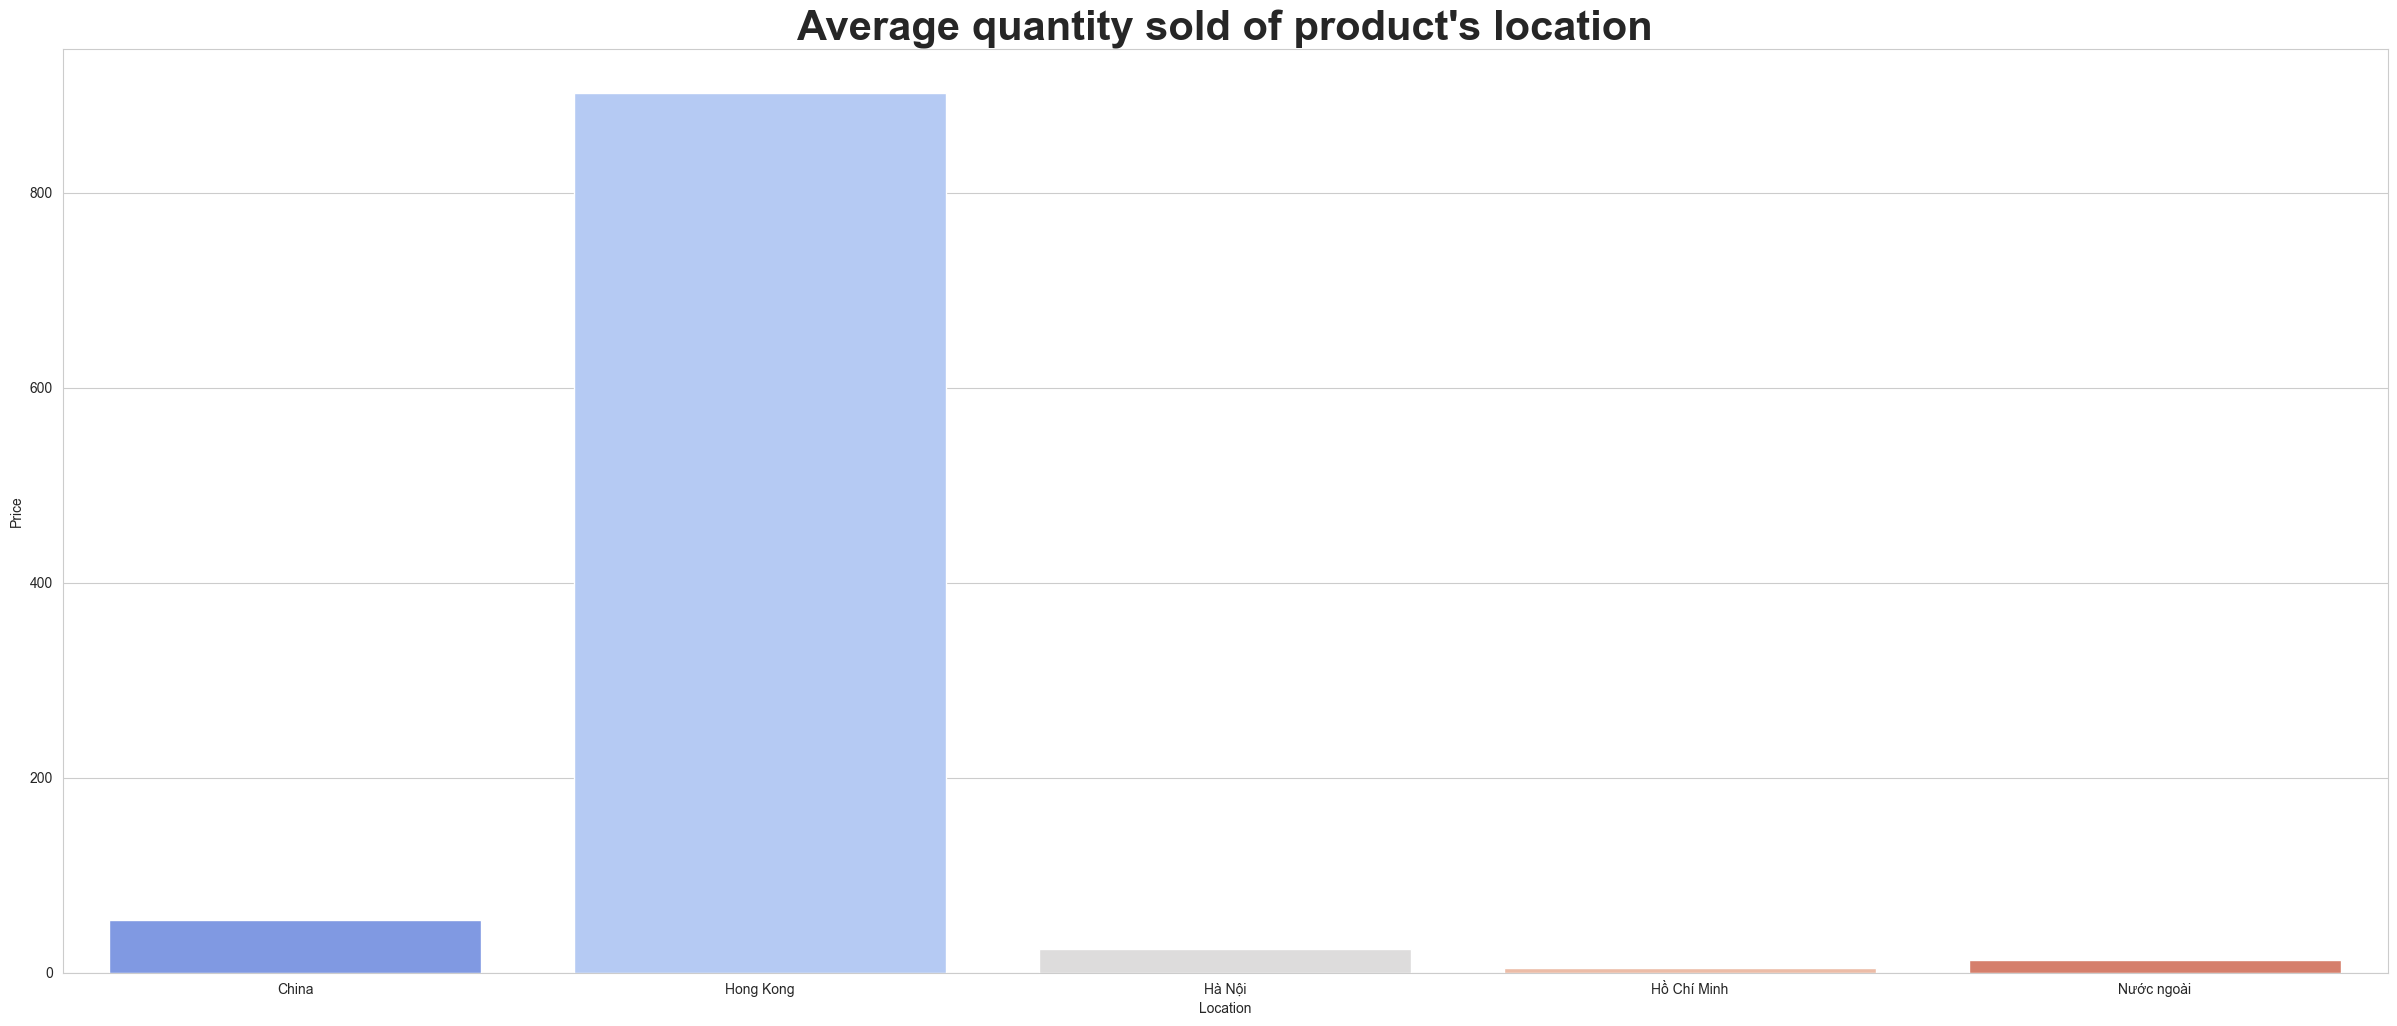

In [35]:
temp = df.groupby('location_of_product')['quantity_sold'].mean().sort_index().reset_index()
plt.figure(figsize = (30, 12))
sns.barplot(data = temp,
            x = 'location_of_product', y = 'quantity_sold', palette = 'coolwarm')
plt.title('Average quantity sold of product\'s location', fontweight = 'bold', fontsize = 30)
plt.xlabel('Location')
plt.ylabel('Price')

It's clear to see that Hai Duong had way more earphones being sold on Lazada than any other provinces combined. This may come from the fact that many retailers in Hai Duong chose Lazada as the platform for selling their earphone products rather than other provinces.

In [ ]:
temp = df.groupby('location_of_product')['review_count'].mean().sort_index().reset_index()
plt.figure(figsize = (30, 12))
sns.barplot(data = temp,
            x = 'location_of_product', y = 'review_count', palette = 'coolwarm')
plt.title('Average review count by product\'s location', fontweight = 'bold', fontsize = 30)
plt.xlabel('Location')
plt.ylabel('Price')

Again, Hai Duong had way more reviews on earphone products than any other locations combined. Thus, we can clearly see that Hai Duong had dominated the earphone market by being able to sell a lot of this product, thus leading to the fact that there were a lot of reviews on the earphone products from Hai Duong 

## *Multivariate analysis*

Speaking of correlations, it's best to view it using heatmaps.

<Axes: >

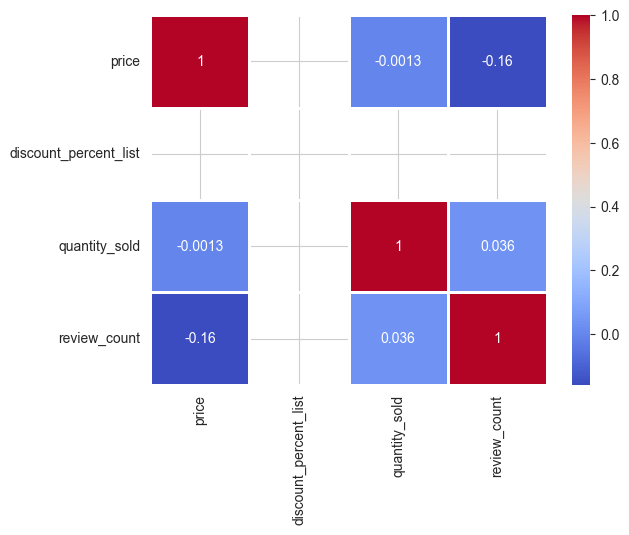

In [37]:
sns.heatmap(df.drop(columns = ['title', 'link_item', 'countReviews', 'location_of_product']).corr(), annot = True, cmap = 'coolwarm', linewidth = 1, linecolor = 'white')

Here are some insights:

1. **Strong Positive Correlation between Quantity Sold and Review Count (0.94)**: This suggests that as more earphones are sold, the number of reviews increases correspondingly. This could be because customers are more likely to leave a review after purchasing a product.

2. **Negative Correlation between Price and Discount Percent List (-0.29)**: This indicates that higher prices might be associated with lower discounts. This could be because sellers are less likely to offer large discounts on expensive items.

3. **Negative Correlation between Price and Quantity Sold (-0.087)**: This suggests that higher prices could potentially lead to fewer sales. This is a common trend in retail where customers are more likely to purchase items that are priced lower.

4. **Almost No Correlation between Discount Percent List and Quantity Sold (0.0099)**: This implies that the amount of discount doesn't significantly affect how many units are sold. This could be because other factors, such as product quality or brand reputation, may be more important to customers than the discount amount.

# Feature engineering and Data preprocessing

## *Feature engineering*

We can additionally extract from products' title 
- If the earphones/headphones have bluetooth connection or not. To do so, we can check from the products' title if it does mention the 'Bluetooth' phrase or not.
- If the earphones/headphones belong to gaming lines or not. To do so, we can check from the products' title if it contains the phrase 'gaming' or 'chơi game' or not.
- If the earphones/headphones are wireless or not. To do so, we can check from the products' title if it contains the phrase 'có dây' or not.
- If the earphones/headphones have microphone or not. To do so, we can check from the products' title if it contains the phrase 'mic' or not.

In [ ]:
df['isBluetooth'] = df['title'].str.contains('Bluetooth', case = False, na = False)
df['isGaming'] = df['title'].str.contains('gaming|chơi game', case = False, na = False)
df['isNotWireless'] = df['title'].str.contains('có dây', case = False, na = False)
df['hasMic'] = df['title'].str.contains('mic', case = False, na = False)
df.head()

,title,price,link_item,discount_percent_list,countReviews,quantity_sold,review_count,location_of_product,isBluetooth,isGaming,isNotWireless,hasMic
0,1-10PCS Tai Nghe Tai Nghe 2 Chấu MIC PTT Cho B...,151000,https://www.lazada.vn/products/1-10pcs-tai-ngh...,0.33,528 Đã bán\n(12)\nNước ngoài,528,12,Nước ngoài,False,False,False,True
1,Tai nghe có dây nhét tai cho điện thoại có mic...,39000,https://www.lazada.vn/products/tai-nghe-co-day...,0.35,948 Đã bán\n(275)\nHà Nội,948,275,Hà Nội,False,False,True,True
2,Tai nghe chụp tai bluetooth 5.0 không dây có â...,81000,https://www.lazada.vn/products/tai-nghe-chup-t...,0.23,926 Đã bán\n(280)\nHồ Chí Minh,926,280,Hồ Chí Minh,True,False,False,False
3,Tai Nghe Gaming Nhét Tai Plextone G25 Micro Lọ...,219000,https://www.lazada.vn/products/tai-nghe-gaming...,0.37,122 Đã bán\n(33)\nHồ Chí Minh,122,33,Hồ Chí Minh,False,True,False,True
4,"Tai nghe Cho Samsung Galaxy ACE, A3, A5, A6, A...",14500,https://www.lazada.vn/products/tai-nghe-cho-sa...,0.28,1.9K Đã bán\n(260)\nHồ Chí Minh,1900,260,Hồ Chí Minh,False,False,False,False


And since we cannot extract any information more than that, we can drop these rows out from the dataset.

In [ ]:
df = df.drop(columns = ['title', 'countReviews'])
df.head()

,price,link_item,discount_percent_list,quantity_sold,review_count,location_of_product,isBluetooth,isGaming,isNotWireless,hasMic
0,151000,https://www.lazada.vn/products/1-10pcs-tai-ngh...,0.33,528,12,Nước ngoài,False,False,False,True
1,39000,https://www.lazada.vn/products/tai-nghe-co-day...,0.35,948,275,Hà Nội,False,False,True,True
2,81000,https://www.lazada.vn/products/tai-nghe-chup-t...,0.23,926,280,Hồ Chí Minh,True,False,False,False
3,219000,https://www.lazada.vn/products/tai-nghe-gaming...,0.37,122,33,Hồ Chí Minh,False,True,False,True
4,14500,https://www.lazada.vn/products/tai-nghe-cho-sa...,0.28,1900,260,Hồ Chí Minh,False,False,False,False


Length of products' name is also one factor worth considering. To extract it, we can use the information from the `link_item`.

Another factor that can be considered is length of URL, or length of `link_item`

In [ ]:
df['length_URL'] = df['link_item'].str.len()
df['product_name'] = df['link_item'].str.extract('products/(.*)\.html')[0]
df['name_length'] = df['product_name'].str.len()
# Drop link_item
df = df.drop(columns = ['product_name', 'link_item'])
df.head()

,price,discount_percent_list,quantity_sold,review_count,location_of_product,isBluetooth,isGaming,isNotWireless,hasMic,length_URL,name_length
0,151000,0.33,528,12,Nước ngoài,False,False,False,True,117,81
1,39000,0.35,948,275,Hà Nội,False,False,True,True,154,118
2,81000,0.23,926,280,Hồ Chí Minh,True,False,False,False,125,89
3,219000,0.37,122,33,Hồ Chí Minh,False,True,False,True,142,106
4,14500,0.28,1900,260,Hồ Chí Minh,False,False,False,False,140,104


## *Data Preprocessing*

In [ ]:
# Use label encoder to encode categorical variables like location_of_product
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['location_of_product'] = le.fit_transform(df['location_of_product'].values.reshape(-1, 1))
df.head()

,price,discount_percent_list,quantity_sold,review_count,location_of_product,isBluetooth,isGaming,isNotWireless,hasMic,length_URL,name_length
0,151000,0.33,528,12,14,False,False,False,True,117,81
1,39000,0.35,948,275,7,False,False,True,True,154,118
2,81000,0.23,926,280,10,True,False,False,False,125,89
3,219000,0.37,122,33,10,False,True,False,True,142,106
4,14500,0.28,1900,260,10,False,False,False,False,140,104


After changing categorical variables into numerical variables, we need to scale all of them down to minimize errors when training models.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in df.columns:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
df.head()

,price,discount_percent_list,quantity_sold,review_count,location_of_product,isBluetooth,isGaming,isNotWireless,hasMic,length_URL,name_length
0,-0.291951,-0.059991,0.033451,-0.296339,0.923970,-0.808863,-0.470900,-0.528763,1.203321,-0.989952,-0.989952
1,-0.391118,0.058159,0.276999,0.596668,-1.237364,-0.808863,-0.470900,1.891206,1.203321,-0.253566,-0.253566
2,-0.353931,-0.650739,0.264241,0.613645,-0.311078,1.236303,-0.470900,-0.528763,-0.831034,-0.830733,-0.830733
3,-0.231742,0.176309,-0.201978,-0.225034,-0.311078,-0.808863,2.123592,-0.528763,1.203321,-0.492394,-0.492394
4,-0.412811,-0.355365,0.829040,0.545736,-0.311078,-0.808863,-0.470900,-0.528763,-0.831034,-0.532198,-0.532198


Then, we have to split the dataset into two sets - which are train set and test set. The perfect ratio would be 80% for the train set and 20% for the test set.

In [ ]:
# This is similar to the method "train_test_split" from "sklearn.model_selection"
def split_data(X,y,test_size=0.2,random_state=0):
    np.random.seed(random_state)                  #set the seed for reproducible results
    indices = np.random.permutation(len(X))       #shuffling the indices
    data_test_size = int(X.shape[0] * test_size)  #Get the test size

    #Separating the Independent and Dependent features into the Train and Test Set
    train_indices = indices[data_test_size:]
    test_indices = indices[:data_test_size]
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    return X_train, y_train, X_test, y_test

# Define X and Y
y = df['quantity_sold']
X = df.drop(['quantity_sold'], axis = 1)
# Now split the dataset into train and test set
X_train, y_train, X_test, y_test = split_data(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Validate the results
X_train.shape, X_test.shape

((1600, 10), (400, 10))

# Standard econometric method

For this segment, we will use all the features that have been created/engineered to predict the quantity sold for each product, using standard econometric method - or, in other words - Multiple Linear Regression. Let's create the class for linear regression algorithm.

In [ ]:
class Multiple_Linear_Regression():
    def __init__ (self):
        self.theta=np.zeros(int(np.random.random()),float)[:,np.newaxis];

    def fit(self, X_train, y_train):
        '''
        Fit data to the model based on the matrix approach to Linear Regression. Actual magic happens here!  
        
        PARAMETERS:
        X_train (numpy.ndarray): Independent variables train data.
        y_train (numpy.ndarray): Dependent variable of train data.

        RETURNS:
        None
        '''
        X_b = np.c_[np.ones(len(X_train)), X_train]
        theta_bst = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
        self.theta = theta_bst

    def predict(self, X_test):
        '''
        Fucntion to predict on new data.
        
        PARAMETERS:
        X_test (numpy.ndarray): Independent variables data.

        RETURNS:
        y_predict (numpy.ndarray): Predicted dependent variable.
        '''
        X_test = np.c_[np.ones((len(X_test), 1)), X_test]
        y_predict = np.dot(X_test, self.theta)

        return y_predict

Now, let's jump to the training part.

In [ ]:
#declaring the "regressor" as an object of the class LinearRegression
regressor = Multiple_Linear_Regression()

#Training 
regressor.fit(X_train, y_train)

In [ ]:
# Predict the results
y_pred = regressor.predict(X_test)
y_pred[:10]

array([ 0.25046853, -0.16933424, -0.31417907, -0.17791853, -0.31224404,
       -0.26688982, -0.17193367, -0.24040212, -0.2857182 , -0.19060769])

### Evaluation metrics:

In [ ]:
def mse(y_preds, y):
    '''
    Mean squared error.
    
    PARAMETERS:
    y_preds (numpy.ndarray): Predictions.
    y (numpy.ndarray): Original dependent variable values.
    
    RETURNS:
    mse (float): Mean squared error.
    '''
    mse = ((y - y_preds)**2).mean()
    return mse

def rmse(y_preds, y):
    '''
    Root Mean squared error.
    
    PARAMETERS:
    y_preds (numpy.ndarray): Predictions.
    y (numpy.ndarray): Original dependent variable values.
    
    RETURNS:
    rmse (float): Root Mean Squared Error.
    '''
    rmse = (((y - y_preds)**2).mean())**(1/2)
    return rmse

def r2(y_preds, y):
    '''
    R square score.
    
    PARAMETERS:
    y_preds (numpy.ndarray): Predictions.
    y (numpy.ndarray): Original dependent variable values.
    
    RETURNS:
    r2 (float): R-Squared score.
    '''
    ssr = sum((y - y_preds) ** 2)
    sst = sum((y - y.mean()) ** 2)
    return 1 - ssr/sst

In [ ]:
mse(y_pred, y_test), rmse(y_pred, y_test), r2(y_pred ,y_test)

(0.15236117110446523, 0.390334691136293, 0.8683054203912304)

### True vs Fitted values

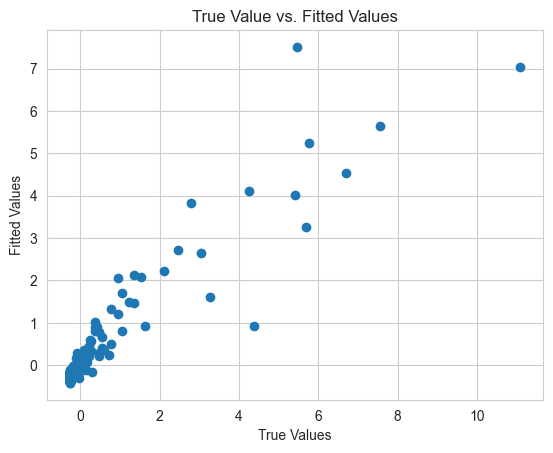

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y_test, y_pred)
ax.set_xlabel('True Values')
ax.set_ylabel('Fitted Values')
ax.set_title('True Value vs. Fitted Values');

The scatter plot titled "True Value vs. Fitted Values" suggests a positive relationship between the True Values (on the x-axis) and the Fitted Values (on the y-axis). This is inferred from the general trend of the data points increasing along both axes.

Here are some specific observations:
1. **Positive Correlation**: As the True Values increase, the Fitted Values also tend to increase. This indicates a positive correlation.
2. **Variability in Predictions**: The spread of points suggests that there may be variability in how well the fitted values predict the true values, especially as true values increase.
3. **Accuracy at Lower Values**: The concentration of points near the origin (where both True Values and Fitted Values are low) indicates that for lower true values, fitted values tend to be more accurate or consistent.

### Coefficient analysis

In [ ]:
regressor.theta

array([-0.00668304, -0.00897168, -0.03128013,  0.91711045, -0.0016899 ,
       -0.03301765, -0.00858114,  0.01546348, -0.01432814,  0.01399626,
        0.01399626])

From this, we can see that location of products really affect products' quantity sold. It's because the demand for certain products can vary based on geographical location. For earphones/headphones - which are technical gadgets - locating in or near the most modern metropolitan is a plus for customers living there/near there as they have a large demand for technical products..

# Using Random Forest Algorithm

## *Implementing Random Forest Regressor*

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred[:10]

array([ 0.38204884, -0.12705272, -0.2597224 , -0.20789894, -0.26866407,
       -0.26649534, -0.23873091, -0.26842053, -0.26866407, -0.22719139])

Now, let's check whether the model is good or not

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MAE: ', mae)
print('MSE: ', mse)
print('MAPE: ', mape)
print('RMSE: ', rmse)
print('R^2: ', r2)

MAE:  0.08410295959285131
MSE:  0.09080846748358506
MAPE:  0.6199845496878943
RMSE:  0.3013444333044582
R^2:  0.9215089851077098


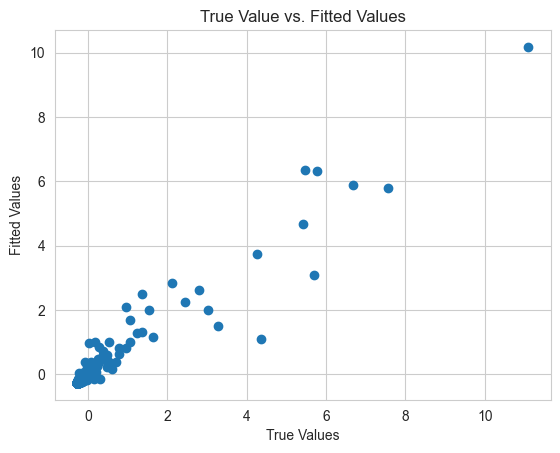

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y_test, y_pred)
ax.set_xlabel('True Values')
ax.set_ylabel('Fitted Values')
ax.set_title('True Value vs. Fitted Values');

## *Hyperparameter tuning*

Hyperparameter tuning is the process of finding the optimal set of hyperparameters for a machine learning model. It is important to tune the hyperparameters of a model to get the best performance on the task at hand.

There are several methods that you can use to tune the hyperparameters of a random forest regressor. Some common methods include:

1. Grid search: In grid search, you specify a grid of hyperparameter values, and the model is trained and evaluated using all possible combinations of these values. Grid search can be time-consuming, as it requires training and evaluating the model multiple times.

2. Random search: In random search, you specify a distribution of hyperparameter values, and a set of random combinations of these values are sampled and used to train and evaluate the model. Random search is often faster than grid search, as it does not evaluate all possible combinations of hyperparameters.

3. Bayesian optimization: In Bayesian optimization, a probabilistic model is used to model the unknown function that maps hyperparameters to the model's performance. The model is then used to guide the search for the optimal hyperparameters.

In general, you should always tune your model as it must help to enhance the algorithm's performance. As you might know, tuning is a really expensive process time-wise. When tuning a Random Forest model it gets even worse as you must train hundreds of trees multiple times for each parameter grid subset.

In this section, we will use `GridSearchCV` from `sklearn.model_selection` package for hyperparameter tuning and compare the results of each one.

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create a RandomForestRegressor object for GridSearchCV tuning
rdr_gridcv_tune = RandomForestRegressor(random_state = 1502)

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [10, 50, 100],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(rdr_gridcv_tune, param_grid, cv = 5)

# Then, fit into the train dataset
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1502),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]})

Here's a breakdown of the code:

In the provided code, a RandomForestRegressor model is set up for hyperparameter tuning using GridSearchCV. The model instance, `rdr_gridcv_tune`, is created with a specified random state for reproducibility. A hyperparameter grid, `param_grid`, is defined to explore different values for `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`. The GridSearchCV object, `grid_search`, is instantiated with the model, hyperparameter grid, and 5-fold cross-validation. Finally, the `fit` method is called on the grid search object using the training dataset (`x_train` and `y_train`), allowing the algorithm to systematically search through the hyperparameter space and identify the best set of parameters. After fitting, the best hyperparameters and the corresponding model can be obtained using `grid_search.best_params_` and `grid_search.best_estimator_`, respectively.

Get the best parameters from hyperparameter tuning

In [ ]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

Having received the best parameters for tuning in, let's implement the new hypeparameter after tuning to predict the results and evaluate them using metrics and graphs.

In [ ]:
# Re-initialize RandomForestRegressor object with hyperparameters
rf_gridtuned = RandomForestRegressor(
    n_estimators = grid_search.best_params_['n_estimators'],
    min_samples_leaf = grid_search.best_params_['min_samples_leaf'],
    min_samples_split = grid_search.best_params_['min_samples_split'],
    max_depth = grid_search.best_params_['max_depth'])

# Fit to train the model
rf_gridtuned.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_gridtuned.predict(X_test)

# Print a few predictions
y_pred[:10]

array([ 0.16972036, -0.15256018, -0.25778206, -0.2464679 , -0.25778206,
       -0.25778206, -0.2464679 , -0.25778206, -0.25778206, -0.2464679 ])

Next, the RandomForestRegressor model is re-initialized with the best hyperparameters obtained from the earlier GridSearchCV process. The `rf_gridtuned` model is created with the optimal values for `n_estimators`, `min_samples_leaf`, `min_samples_split`, and `max_depth` extracted from the `grid_search.best_params_` dictionary. The model is then fitted to the training data using the `fit` method. Subsequently, predictions are made on the test set (`x_test`), and the first 10 predictions are printed using `y_pred[:10]`. This final part demonstrates the application of the tuned model to make predictions on new data.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
# Create a table for better look
metrics_df = pd.DataFrame([mae, mse, mape, rmse, r2],
                          index = ['MAE', 'MSE', 'MAPE', 'RMSE', 'R^2'],
                          columns = ['Values'])
metrics_df

,Values
MAE,0.089426
MSE,0.090243
MAPE,0.678123
RMSE,0.300404
R^2,0.921998


As we can see, after tuning using `GridSearchCV`, the performance of predicting has enhanced quite significantly. The RMSE has decreased a bit to 30%, indicating that the prediction is less far off the actual values than without tuning. Moreover, $R^2$ has enhanced slightly to about 92.2%, which means that the independent variables can explain about 92.2% the meaning of the dependent variable. This optimistically means the model was doing an excellent job in predicting quantity sold.

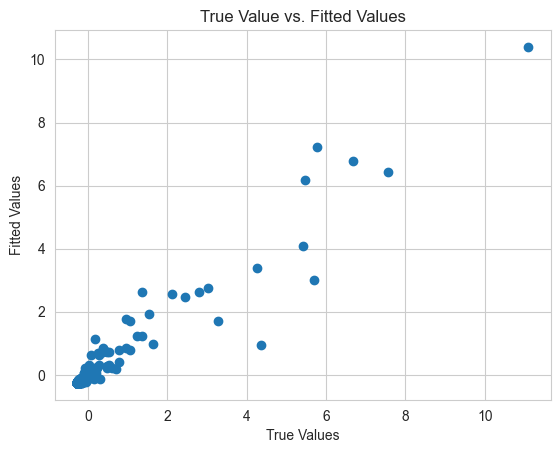

In [ ]:
fig, ax = plt.subplots()

ax.scatter(y_test, y_pred)
ax.set_xlabel('True Values')
ax.set_ylabel('Fitted Values')
ax.set_title('True Value vs. Fitted Values');

Here are some observations:
1. Concentration near Origin: The concentration of points near the origin (0,0) suggests that for lower true values of quantities sold, the model’s predictions are quite accurate. This indicates that the model is performing well for items with lower sales quantities.
2. Spread towards Higher Values: As we move towards higher true values (towards 10,10), there is more variance in fitted values. This indicates less accuracy in predictions for items with higher sales quantities. The model might need to be improved to handle these cases better.
3. Outlier Detection: There is one distinct outlier near (10,10). This could suggest an instance where both actual and predicted sales were high. However, it could also indicate potential overfitting or anomalies in either prediction or actual data.
In summary, the model seems to perform well for lower sales quantities. 

Since Random Forest Regressor is a tree-based algorithm, we cannot find the coefficients just like the Linear Regresion one. However, there's one way to see which feature affects quantity sold the most - that is - feature importance plot

<Axes: title={'center': "Features' importances based on Random Forest Regeressor"}>

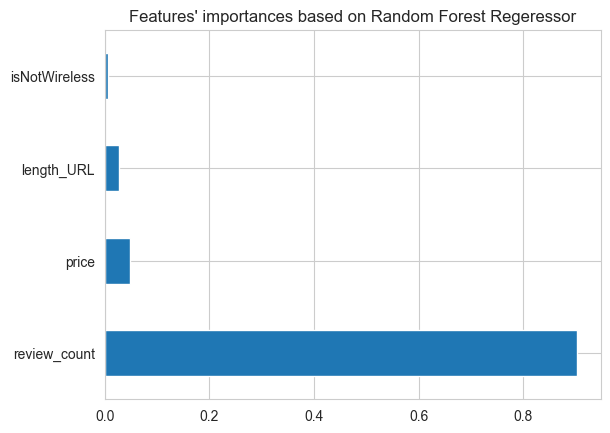

In [ ]:
feat_importances = pd.Series(rf_gridtuned.feature_importances_, index=X_train.columns)
feat_importances.nlargest(4).plot(kind = 'barh', title = 'Features\' importances based on Random Forest Regeressor')

This graph illustrates the 4 most important features that affect quantity sold of earphone products using Random Forest Regressor algorithm. Here are some insights: 

1. We can clearly see that `review_count` affects the quantity sold of the product most. This suggests that the number of reviews a product has received is the most significant predictor of its sales volume according to the Random Forest Regressor model. Products with more reviews might be more visible or more trusted by customers, leading to higher sales.

2. The ‘price’ feature is the second most important. This indicates that the price of the earphones significantly influences their sales volume. This could be because customers often consider price when deciding whether to purchase a product.

3. The ‘length_URL’ feature has a lower importance score. While it does have some influence on the prediction, it is less significant than the number of reviews and the price. The length of the URL might be related to the product’s listing details or how the product is categorized on Lazada.

4. The ‘isNotWireless’ feature has the lowest importance score among the 4. This suggests that whether the earphones are wireless or not does not significantly influence their sales volume according to this model.

In summary, the model suggests that the number of reviews and the price of the earphones are the most important factors in predicting sales volume on Lazada, while the length of the URL and whether the earphones are wireless are less important. 

# Comparison

**Metrics comparison**

Based on the provided metrics, we can compare the performance of the Linear Regression model and the Random Forest Regressor model as follows:

- **Mean Squared Error (MSE)**: This is a measure of how close a fitted line is to data points. The smaller the MSE, the closer the fit is to the data. In this case, the MSE of the Random Forest Regressor (0.090243) is lower than the MSE of the Linear Regression model (0.15236117110446523), which means the Random Forest model has less error in the prediction.

- **Root Mean Squared Error (RMSE)**: This is the square root of the mean square error. It measures the standard deviation of the residuals. Similar to MSE, a lower value of RMSE indicates a better fit to the data. Here, the RMSE of the Random Forest Regressor (0.300404) is lower than the RMSE of the Linear Regression model (0.390334691136293), suggesting that the Random Forest model has less prediction error.

- **Coefficient of Determination (R^2)**: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The closer R^2 is to 1, the better the model fits the data. In this case, the R^2 of the Random Forest Regressor (0.921998) is higher than the R^2 of the Linear Regression model (0.8683054203912304), indicating that the Random Forest model explains the data better.

In conclusion, based on these metrics, the **Random Forest Regressor** appears to perform better than the Linear Regression model for predicting the quantity sold of earphones on Lazada. 

**Actual vs fitted comparison**

Based on the scatter plot of the Random Forest regressor and Multiple Linear Regression, here are some insights:

- **Overall Fit**: The points in Random Forest regressor's plot are more tightly clustered around the line where true values equal fitted values compared to the Multiple Linear Regression model. This indicates that the Random Forest regressor has a better overall fit and is more accurate in predicting the quantity sold of earphones.

- **Prediction Accuracy**: Similar to the Multiple Linear Regression model, the Random Forest regressor is more accurate in predicting smaller quantities sold. However, the spread of points for higher quantities sold is less in the Random Forest regressor plot, indicating that it is more accurate for higher sales figures compared to the Multiple Linear Regression model.

- **Residuals**: The residuals (the difference between the actual and predicted values) are smaller in the Random Forest regressor compared to the Multiple Linear Regression model. This suggests that the Random Forest regressor has captured more information in the data and made more accurate predictions.

Comparing these insights with the previous insights from the Multiple Linear Regression model, it appears that the Random Forest regressor provides a better fit and more accurate predictions for the quantity sold of earphones on Lazada. This could be due to the ability of the Random Forest regressor to capture more complex patterns in the data. 

**Features' importances comparison**

Looking through the coefficients, Multiple Linear Regression suggests that location of products have way more impact on quantity sold than other factors. Whereas, Random Forest Regressor suggests that number of reviews on the products have way more impact on the quantity sold of earphone products. What's more, number of reviews tend to have negative impact if we use the coefficients from Multiple Linear Regression model.